# Visualization of spatial data using KeplerGL

In [ ]:
from keplergl import KeplerGl 
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
import osmnx as ox

def visualize_file(shape, to_crs_value = None):
    
    map = KeplerGl(height=500)
    gpdshape1 = gpd.read_file(shape)
    
    if(to_crs_value != None):
        gpdshape1.crs = "EPSG:4326"
        
    map.add_data(data=gpdshape1, name=shape)
    shape = shape.split('/')[-1]
    file_name = shape.split('.')[-2]
    map.save_to_html(file_name='Visualizations/' + file_name + '.html', read_only=True)    
    
def  visualize_join(shape_1, shape_2):
    
    map_1 = KeplerGl(height=500)
    gpdshape1 = gpd.read_file(shape_1)
    shape_1 = shape_1.split('/')[-1]
    file_1 = shape_1.split('.')[-2]
    gpdshape1.crs = "EPSG:4326"
    
    map_2 = KeplerGl(height=500)
    gpdshape2 = gpd.read_file(shape_2)
    shape_2 = shape_2.split('/')[-1]
    file_2 = shape_2.split('.')[-2]
    
    map_3 = KeplerGl(height=500)
    join_result = gpd.sjoin(gpdshape1, gpdshape2, how="inner", op='contains')
    map_3.add_data(data=join_result, name="join_result")
    map_3.save_to_html(file_name='Visualizations/'+file_1+'_join_'+file_2+'.html', read_only=True)

In [ ]:
visualize_file("Datasets/shape_files/gadm36_IND_0.shp", 4362)

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://geopandas.org/_images/overlay_operations.png")

# Spatial Join on CPU and GPU without indexing and splitting

In [ ]:
import time
import geopandas as gpd
from numba.extending import overload
import matplotlib.pyplot as plt

def sjoin_without_indexing(data_1, data_2, device = 'CPU', plot = True):
    start_time = time.time()
    join_result = gpd.GeoDataFrame(gpd.sjoin(data_1, data_2, how="inner", op='intersects'))
    end_time = time.time()
    print("S-join without splitting on {0} = {1}".format(device, end_time - start_time))
    
    if plot:
        join_result.plot(ec = "#0b1878", figsize=(15,15))
    
    return join_result

@overload(sjoin_without_indexing)
def gpu_sjoin_without_indexing(data1, data2, plot = True):
    return sjoin_without_indexing(data1, data2, device = 'GPU', plot = plot)

In [ ]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd

gdb_data = gpd.read_file("Datasets/Geodatabase_format/gROADS-v1-oceania-east.gdb")
data_3 = gpd.read_file("Datasets/shape_files/gadm36_IND_3.shp").set_crs(gdb_data.crs)

# sjoin_without_indexing(gdb_data, data_3, plot = False)

result = gpu_sjoin_without_indexing(gpd.GeoDataFrame(gdb_data["geometry"]), gpd.GeoDataFrame(data_3["geometry"]), plot = True)

In [ ]:
gdb_data.plot()
data_3.plot()

In [ ]:
result["geometry"]

In [ ]:
data_3["geometry"]

In [ ]:
gdb_data["geometry"]

In [ ]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd

gdb_data = gpd.read_file("Datasets/Geodatabase_format/gROADS-v1-oceania-east.gdb")
data_3 = gpd.read_file("Datasets/shape_files/gadm36_IND_3.shp").set_crs(gdb_data.crs)
print(gdb_data)
print("\n\n\n\n\n", data_3)

In [ ]:
for i in data_3["geometry"].iloc(0):
    print(i)

# Spatial Join on CPU and GPU with indexing and without splitting

In [ ]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

from numba.extending import overload

import matplotlib.pyplot as plt
import time

def sjoin_with_indexing(data_1, data_2, device = 'CPU', plot = True):
    
#     convert input data to Multipolygon as needed by sjoin
    geometry_1 = data_1['geometry'].iloc[0]
    if isinstance(geometry_1, Polygon):
        geometry_1 = MultiPolygon([geometry_1])
        
    geometry_2 = data_2['geometry'].iloc[0]
    if isinstance(geometry_2, Polygon):
        geometry_2 = MultiPolygon([geometry_2])
        
    start_time = time.time()
#     indexing data_1
    sindex_1 = data_1.sindex
    sindex_2 = data_2.sindex
    
#     filter phase
    possible_indices = list(sindex_1.intersection(sindex_2.bounds))
    possible_matches = data_1.iloc[possible_indices]
    
#     refinement phase
    precise_matches = possible_matches[possible_matches.intersects(geometry_2)]
    # cannot use index structure of data 2 for intersects operation, accepts Series datatype only     
    end_time = time.time()
    
#     plotting the sjoin results 
    points_within_geometry = precise_matches
    points_outside_geometry = data_1[~data_1.isin(points_within_geometry)]
    
    if plot:
        points_within_geometry.plot(ec = "#0b1878", figsize=(15,15))
    
    print("S-join without splitting on {0} = {1}".format(device, end_time - start_time))
    
@overload(sjoin_with_indexing)
def gpu_sjoin_with_indexing(data_1, data_2, device = 'CPU', plot = True):
    sjoin_with_indexing(data_1, data_2, device = 'GPU', plot = True)
    

gdb_data = gpd.read_file("Datasets/Geodatabase_format/gROADS-v1-oceania-east.gdb")
data_3 = gpd.read_file("Datasets/shape_files/gadm36_IND_3.shp").set_crs(gdb_data.crs)


# sjoin_with_indexing(gdb_data, data_3, plot = False)

gpu_sjoin_with_indexing(gdb_data, data_3)

# Output isn't correct

# Convert wkt to GeodataFrames

In [ ]:
import geopandas as gpd

# data = gpd.read_file("DatasetsL/land-polygons-complete-4326/land_polygons.shp")
# data_NZ = gpd.read_file("DatasetsL/places_dump_20110628/places_dump_NZ.geojson")
data_result =  gpd.read_file("Result_within.shp")

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax, color='grey')
data_NZ.plot(ax=ax, marker='o', color='blue', markersize=6)
data_result.plot(ax=ax, marker='o', color='red', markersize=6)
plt.show()

In [ ]:
import geopandas as gpd

data =  gpd.read_file("./DatasetsL/NHD_H_National_GDB/NHD_H_National_GDB.gdb")
data_land = gpd.read_file("DatasetsL/land-polygons-complete-4326/land_polygons.shp")
data_LA = ox.geocode_to_gdf('Los Angeles, California, USA') # Polygon

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
data_land.plot(ax=ax, color='grey')
data.plot(ax=ax, marker='o', color='red', markersize=6)
data_LA.plot(ax=ax, color='green')
             
plt.show()

In [ ]:
data_LA.plot()

In [ ]:
import geopandas as gpd
import osmnx as ox

points = gpd.read_file("./Datasets/Point_dataset/LA_point_dataset.shp") # Points
LA = ox.geocode_to_gdf('Los Angeles, California, USA') # Polygon
NZ = gpd.read_file("DatasetsL/places_dump_20110628/places_dump_NZ.geojson")  # Points

In [ ]:
print("LA road intersection (point):", len(points))
print("LA boundary (polygon):", len(LA))
print("NZ world points (points):", len(NZ))

In [ ]:
print(LA['geometry'])

In [5]:
import geopandas as gp

def vertices(df):

    for i, row in df.iterrows():
        
        multi = row.geometry.type.startswith("Multi")

        if multi:
            n = 0
            # iterate over all parts of multigeometry
            for part in row.geometry:
                n += len(part.exterior.coords)
        else: # if single geometry like point, linestring or polygon
            n = len(row.geometry.exterior.coords)

        return n
    
n = vertices(mex)
print(n)

75502


In [ ]:
import geopandas as gpd
import osmnx as ox

hospitals = gpd.read_file("Datasets/India_hospitals/india_hospitals_point.shp")  # Points
len(hospitals)



In [ ]:
kar = ox.geocode_to_gdf('Karnataka, India') # Polygon

In [ ]:
kar.plot()

In [ ]:
kar

In [1]:
import geopandas as gpd

# scary = gpd.read_file("DatasetsL/places_dump_20110628/places_dump_GB.geojson")

/home/sjoin/capstone/capstone_venv/lib/python3.6/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [2]:
len(scary)

363348

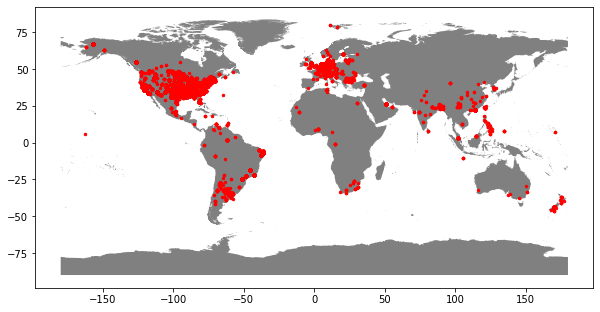

In [4]:
import geopandas as gpd

scary = gpd.read_file("DatasetsL/places_dump_20110628/places_dump_NL.geojson")
data_land = gpd.read_file("DatasetsL/land-polygons-complete-4326/land_polygons.shp")

import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
data_land.plot(ax=ax, color='grey')
scary.plot(ax=ax, marker='o', color='red', markersize=6)
             
plt.show()

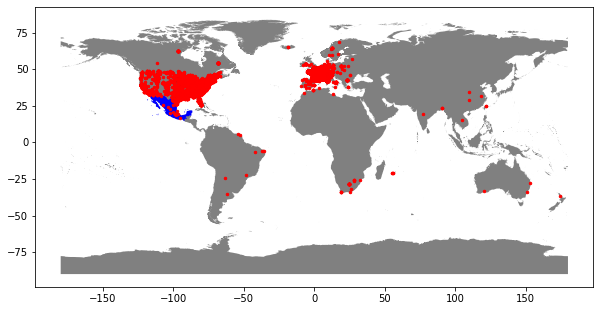

In [6]:
import geopandas as gpd
scary = gpd.read_file("DatasetsL/places_dump_20110628/places_dump_FR.geojson")
data_land = gpd.read_file("DatasetsL/land-polygons-complete-4326/land_polygons.shp")

import osmnx as ox
mex = ox.geocode_to_gdf('Mexico') # Polygon

import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 10))
data_land.plot(ax=ax, color='grey')
mex.plot(ax=ax, color='blue')
scary.plot(ax=ax, marker='o', color='red', markersize=6)
             
plt.show()

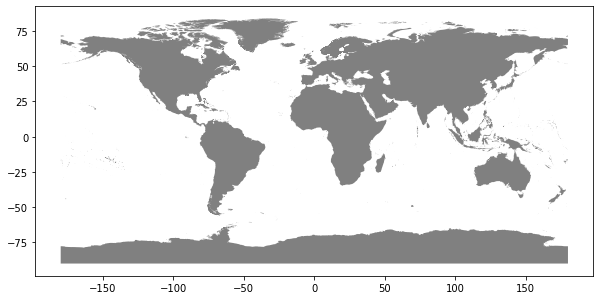

In [9]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
can.plot(ax=ax, color='green')
data_land.plot(ax=ax, color='grey')
             
plt.show()

In [3]:
import geopandas as gpd
scary = gpd.read_file("DatasetsL/places_dump_20110628/places_dump_FR.geojson")

import osmnx as ox
mex = ox.geocode_to_gdf('Mexico') # Polygon

/home/sjoin/capstone/capstone_venv/lib/python3.6/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [4]:
print(len(scary))


189372


In [ ]:
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

def add_geometry(data, ax, geometry = 'polygon', fc = '#cccccc', ec='k'):
    
    if geometry == 'polygon':
        for polygon in data:
            patch = PolygonPatch(polygon, fc=fc, ec=ec, alpha=0.5, zorder=2)
            ax.add_patch(patch)
            
    elif geometry == 'point':
        ax.scatter(x=data['x'], y=data['y'], s=1, c=fc, linewidth=0, zorder=1)

POLYGON ((74.05439079999999 14.8165253, 74.0546322 14.8164579, 74.05471799999999 14.816323, 74.0548843 14.8162764, 74.05501 14.81639, 74.0554368 14.8166083, 74.0555227 14.816572, 74.0556782 14.816266, 74.0558338 14.8161934, 74.05600010000001 14.8162401, 74.0561235 14.816266, 74.0563434 14.8161571, 74.05650970000001 14.8159548, 74.05682 14.8158, 74.05695 14.81584, 74.05699250000001 14.8159496, 74.0571159 14.816209, 74.05674999999999 14.81654, 74.05634999999999 14.81711, 74.05618 14.81728, 74.056 14.81726, 74.0558016 14.8171269, 74.0555227 14.8169609, 74.0552115 14.816878, 74.0550238 14.8167742, 74.0547985 14.8168209, 74.0544605 14.8166238, 74.05439079999999 14.8165253))
POLYGON ((74.0565151 14.8202333, 74.0566117 14.8200673, 74.056735 14.8198236, 74.0568531 14.819585, 74.0569496 14.8195747, 74.0570944 14.8195954, 74.0571427 14.819305, 74.05766 14.81893, 74.05783 14.81885, 74.05804999999999 14.81888, 74.0582 14.81901, 74.05809000000001 14.81912, 74.05808 14.81928, 74.05817999999999 14.81

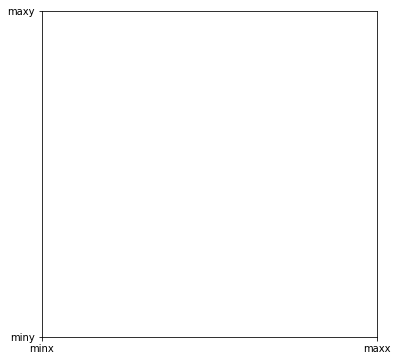

In [15]:
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

import osmnx as ox
data_2 = ox.geocode_to_gdf('Karnataka, India') 
geometry = data_2['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    print(polygon)
    patch = PolygonPatch(polygon, fc='#cccccc', ec='black', alpha=0.5, zorder=2)
    ax.add_patch(patch)

west, south, east, north = data_2.bounds
ax.set_xlim(west, east)
ax.set_ylim(south, north)
plt.show()

<AxesSubplot:>

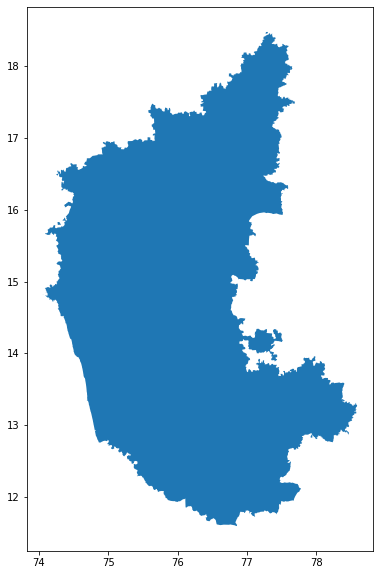

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
data_2.plot(ax = ax)

In [9]:
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width = 0.1)

AttributeError: 'MultiPolygon' object has no attribute 'plot'

POLYGON ((74.05439079999999 14.8165253, 74.0544605 14.8166238, 74.0547985 14.8168209, 74.0550238 14.8167742, 74.0552115 14.816878, 74.0555227 14.8169609, 74.0558016 14.8171269, 74.056 14.81726, 74.05618 14.81728, 74.05634999999999 14.81711, 74.05674999999999 14.81654, 74.0571159 14.816209, 74.05699250000001 14.8159496, 74.05695 14.81584, 74.05682 14.8158, 74.05650970000001 14.8159548, 74.0563434 14.8161571, 74.0561235 14.816266, 74.05600010000001 14.8162401, 74.0558338 14.8161934, 74.0556782 14.816266, 74.0555227 14.816572, 74.0554368 14.8166083, 74.05501 14.81639, 74.0548843 14.8162764, 74.05471799999999 14.816323, 74.0546322 14.8164579, 74.05439079999999 14.8165253))
POLYGON ((74.0565151 14.8202333, 74.0565848 14.8203785, 74.05668679999999 14.8204355, 74.0569818 14.8203941, 74.05718 14.82037, 74.05744 14.82047, 74.05783 14.82029, 74.05800000000001 14.82017, 74.05812 14.82024, 74.0582 14.82036, 74.05813000000001 14.82064, 74.05816 14.82076, 74.05831999999999 14.82085, 74.05855 14.8208

POLYGON ((75.03997606086956 15.2849988115942, 75.03997606086956 15.18525718695652, 74.9414175347826 15.18525718695652, 74.9414175347826 15.2849988115942, 75.03997606086956 15.2849988115942))
POLYGON ((75.03997606086956 15.18525718695652, 75.03997606086956 15.08551556231884, 74.9414175347826 15.08551556231884, 74.9414175347826 15.18525718695652, 75.03997606086956 15.18525718695652))
POLYGON ((75.03997606086956 15.08551556231884, 75.03997606086956 14.98577393768116, 74.9414175347826 14.98577393768116, 74.9414175347826 15.08551556231884, 75.03997606086956 15.08551556231884))
POLYGON ((75.03997606086956 14.98577393768116, 75.03997606086956 14.88603231304348, 74.9414175347826 14.88603231304348, 74.9414175347826 14.98577393768116, 75.03997606086956 14.98577393768116))
POLYGON ((75.03997606086956 14.88603231304348, 75.03997606086956 14.7862906884058, 74.9414175347826 14.7862906884058, 74.9414175347826 14.88603231304348, 75.03997606086956 14.88603231304348))
POLYGON ((75.03997606086956 14.7862

POLYGON ((75.6313272173913 16.48189830724638, 75.6313272173913 16.3821566826087, 75.53276869130434 16.3821566826087, 75.53276869130434 16.48189830724638, 75.6313272173913 16.48189830724638))
POLYGON ((75.6313272173913 16.3821566826087, 75.6313272173913 16.28241505797101, 75.53276869130434 16.28241505797101, 75.53276869130434 16.3821566826087, 75.6313272173913 16.3821566826087))
POLYGON ((75.6313272173913 16.28241505797101, 75.6313272173913 16.18267343333333, 75.53276869130434 16.18267343333333, 75.53276869130434 16.28241505797101, 75.6313272173913 16.28241505797101))
POLYGON ((75.6313272173913 16.18267343333333, 75.6313272173913 16.08293180869565, 75.53276869130434 16.08293180869565, 75.53276869130434 16.18267343333333, 75.6313272173913 16.18267343333333))
POLYGON ((75.6313272173913 16.08293180869565, 75.6313272173913 15.98319018405797, 75.53276869130434 15.98319018405797, 75.53276869130434 16.08293180869565, 75.6313272173913 16.08293180869565))
POLYGON ((75.6313272173913 15.9831901840

POLYGON ((75.82844426956521 14.88603231304348, 75.82844426956521 14.7862906884058, 75.72988574347825 14.7862906884058, 75.72988574347825 14.88603231304348, 75.82844426956521 14.88603231304348))
POLYGON ((75.82844426956521 14.7862906884058, 75.82844426956521 14.68654906376812, 75.72988574347825 14.68654906376812, 75.72988574347825 14.7862906884058, 75.82844426956521 14.7862906884058))
POLYGON ((75.82844426956521 14.68654906376812, 75.82844426956521 14.58680743913043, 75.72988574347825 14.58680743913043, 75.72988574347825 14.68654906376812, 75.82844426956521 14.68654906376812))
POLYGON ((75.82844426956521 14.58680743913043, 75.82844426956521 14.48706581449275, 75.72988574347825 14.48706581449275, 75.72988574347825 14.58680743913043, 75.82844426956521 14.58680743913043))
POLYGON ((75.82844426956521 14.48706581449275, 75.82844426956521 14.38732418985507, 75.72988574347825 14.38732418985507, 75.72988574347825 14.48706581449275, 75.82844426956521 14.48706581449275))
POLYGON ((75.828444269565

POLYGON ((76.3212369 14.88603231304348, 76.3212369 14.7862906884058, 76.22267837391304 14.7862906884058, 76.22267837391304 14.88603231304348, 76.3212369 14.88603231304348))
POLYGON ((76.3212369 14.7862906884058, 76.3212369 14.68654906376812, 76.22267837391304 14.68654906376812, 76.22267837391304 14.7862906884058, 76.3212369 14.7862906884058))
POLYGON ((76.3212369 14.68654906376812, 76.3212369 14.58680743913043, 76.22267837391304 14.58680743913043, 76.22267837391304 14.68654906376812, 76.3212369 14.68654906376812))
POLYGON ((76.3212369 14.58680743913043, 76.3212369 14.48706581449275, 76.22267837391304 14.48706581449275, 76.22267837391304 14.58680743913043, 76.3212369 14.58680743913043))
POLYGON ((76.3212369 14.48706581449275, 76.3212369 14.38732418985507, 76.22267837391304 14.38732418985507, 76.22267837391304 14.48706581449275, 76.3212369 14.48706581449275))
POLYGON ((76.3212369 14.38732418985507, 76.3212369 14.28758256521739, 76.22267837391304 14.28758256521739, 76.22267837391304 14.38

POLYGON ((76.73996767043953 17.87828105217391, 76.74014560000001 17.8988893, 76.7430018 17.8986917, 76.7448057 17.898719, 76.7459511 17.8986645, 76.7475259 17.898392, 76.7495303 17.8976563, 76.7539828 17.8974656, 76.76381720000001 17.8989461, 76.7697587 17.9000513, 76.77549019999999 17.8889813, 76.77678527486695 17.87828105217391, 76.73996767043953 17.87828105217391))
POLYGON ((76.81042167742585 17.87828105217391, 76.8112201 17.8853282, 76.81402953043478 17.88525313975113, 76.81402953043478 17.87828105217391, 76.81042167742585 17.87828105217391))
POLYGON ((76.81402953043478 17.67879780289855, 76.81402953043478 17.57905617826087, 76.71547100434782 17.57905617826087, 76.71547100434782 17.67879780289855, 76.81402953043478 17.67879780289855))
POLYGON ((76.81402953043478 17.57905617826087, 76.81402953043478 17.47931455362319, 76.71547100434782 17.47931455362319, 76.71547100434782 17.57905617826087, 76.81402953043478 17.57905617826087))
POLYGON ((76.81402953043478 17.47931455362319, 76.81402

POLYGON ((77.48272475434071 16.98060643043478, 77.4827274 16.9805565, 77.48231920000001 16.9795756, 77.48222060000001 16.9788221, 77.48231199999999 16.9784912, 77.4823351 16.9773776, 77.4820385 16.9773512, 77.48192109999999 16.9761524, 77.4818897 16.9753626, 77.48184860000001 16.9748888, 77.48182730000001 16.9747454, 77.48180120000001 16.9742571, 77.4821486 16.9733712, 77.4821572 16.973213, 77.4821264 16.9731045, 77.4820088 16.973122, 77.4819383 16.97307, 77.48179880000001 16.9725208, 77.48099360000001 16.971409, 77.4803122 16.9703649, 77.4797988 16.9695906, 77.4780952 16.9688265, 77.4780404 16.9684496, 77.4777224 16.9682485, 77.4769441 16.966337, 77.47689509999999 16.9662264, 77.4768507 16.9661053, 77.47643909999999 16.9647611, 77.4763888 16.964614, 77.4763064 16.9644943, 77.4756788 16.9635208, 77.47563510000001 16.9634158, 77.4755017 16.9632397, 77.4739702 16.9595002, 77.47254909999999 16.957871, 77.47027490000001 16.9582851, 77.4697444 16.9583675, 77.4684962 16.9586086, 77.465798500

POLYGON ((77.59894745492839 12.49223332173913, 77.5872025 12.4835477, 77.5839531 12.4785472, 77.59324340000001 12.4756452, 77.59987080000001 12.4757025, 77.60249773913043 12.47541301115702, 77.60249773913043 12.39249169710145, 77.50393921304348 12.39249169710145, 77.50393921304348 12.49223332173913, 77.59894745492839 12.49223332173913))
POLYGON ((77.60249773913043 12.39249169710145, 77.60249773913043 12.35865149609526, 77.599519 12.3559051, 77.59834600000001 12.3497748, 77.57761480000001 12.3318677, 77.56512650000001 12.3051078, 77.55867430000001 12.3057622, 77.5530536 12.2981347, 77.55195478904275 12.29275007246377, 77.50393921304348 12.29275007246377, 77.50393921304348 12.39249169710145, 77.60249773913043 12.39249169710145))
POLYGON ((77.55195478904275 12.29275007246377, 77.5517462 12.2917279, 77.534183 12.2909859, 77.5325677 12.2890519, 77.5272155 12.277456, 77.5148872 12.2751404, 77.50814250000001 12.2758568, 77.50393921304348 12.27957497536805, 77.50393921304348 12.29275007246377,

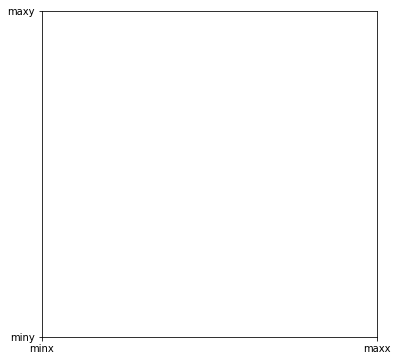

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry_cut:
    print(polygon)
    patch = PolygonPatch(polygon, alpha=0.5, zorder=2)
    ax.add_patch(patch)

west, south, east, north = data_2.bounds
ax.set_xlim(west, east)
ax.set_ylim(south, north)
plt.show()